# Gaussian Process Analysis Notebook for Value Function

## Note that these plots correspond to Gaussian Processes that were trained individually for each subject

In [1]:
#Import necessary packages
import sys
import csv
import numpy as np
import gpflow
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import pandas as pd
import h5py
from sklearn.model_selection import train_test_split
import tensorflow as tf
from scipy.cluster.vq import kmeans
tf.set_random_seed(1234)
import pickle
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
ps_colors = ['#EFEFEF', '#EC4941', '#25A7DD','#060101']
import seaborn as sns
from scipy import stats
from scipy.stats import ncx2, pearsonr
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import PKutils
from sklearn.metrics import roc_curve,auc,log_loss
from sklearn.linear_model import LogisticRegression

/home/krm58/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/krm58/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Make KDE Plots

In [6]:
#Takes a while to run from scratch
if os.path.exists("EVdata.npy"): #if we've run this cell before, just load in
    EVdata = np.load("EVdata.npy")
else:
    EVs = []
    for subID in np.arange(82):
        print("Processing Subject {}".format(subID))
        EVs.append(PKutils.calculateExtraEV(subID))
        np.save("EVdata.npy",EVdata)

In [11]:
df = PKutils.loaddf()
df["EV"] = EVdata
humandf = df[df["opp"]==1]
cpudf = df[df["opp"]==0]
subdf = df[df["subID"]==3]
subhumandf = subdf[subdf["opp"]==1]
subcpudf = subdf[subdf["opp"]==0]

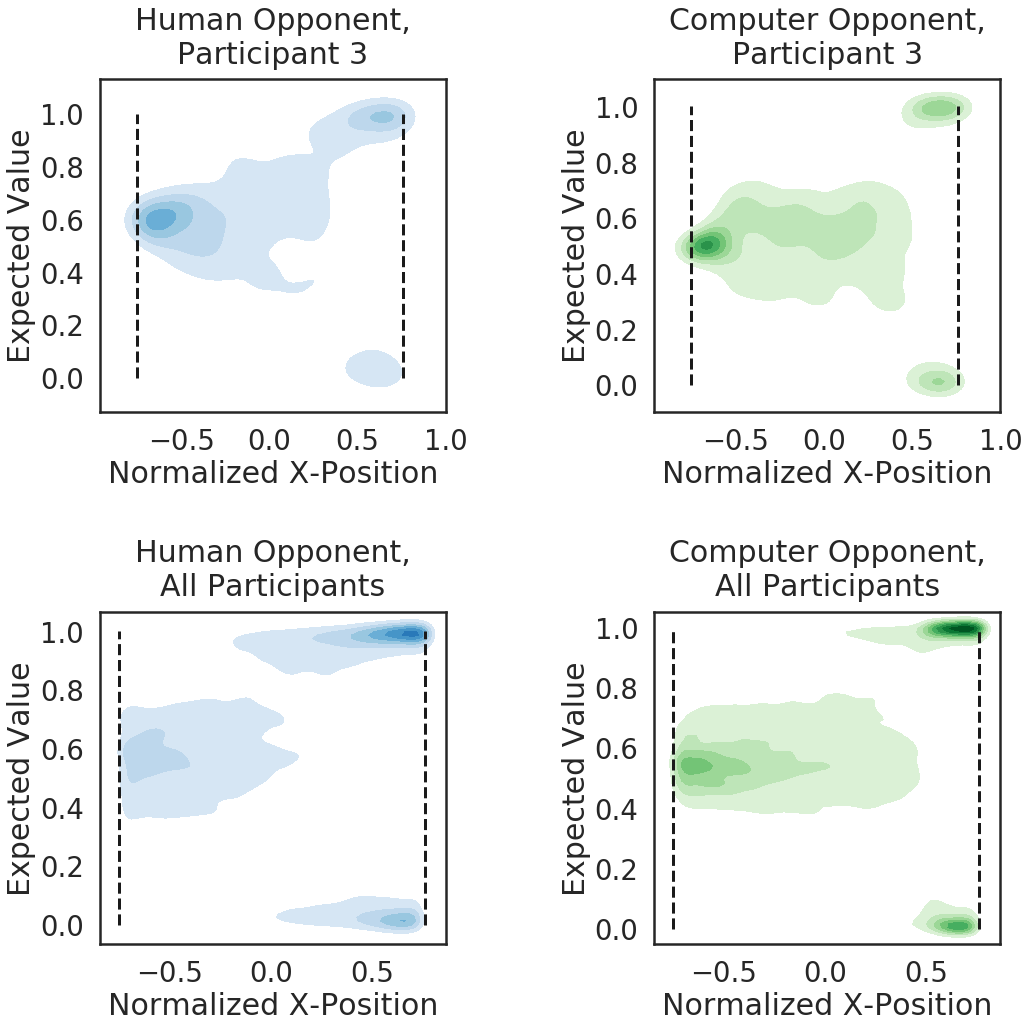

In [15]:
sns.set(style="white",context='poster', font_scale=1.25,font='arial')
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(15,15))
levels = np.linspace(0, 6.5,10)

#Plot 1
humankdesub3 = sns.kdeplot(subhumandf["ball_xpos"], subhumandf["EV"],shade=True, shade_lowest=False,cmap="Blues",ax=ax1,levels=levels);
ax1.vlines(-.75, 0,1,linestyles='dashed')
ax1.vlines(.76,0,1,linestyles='dashed')
ax1.set_title("Human Opponent,\nParticipant 3",y=1.03)
ax1.set_yticks([0.0,0.2,0.4,0.6,0.8,1.0])
ax1.set_xlabel("Normalized X-Position")
ax1.set_ylabel("Expected Value")

#Plot 2
cpukdesub3 = sns.kdeplot(subcpudf["ball_xpos"], subcpudf["EV"],shade=True, shade_lowest=False, ax=ax2,cmap="Greens",levels=levels)
ax2.vlines(-.75, 0,1,linestyles='dashed')
ax2.vlines(.76,0,1,linestyles='dashed')
ax2.set_title("Computer Opponent,\nParticipant 3",y=1.03)
ax2.set_xlabel("Normalized X-Position")
ax2.set_ylabel("Expected Value")

#Plot 3
humankdeall = sns.kdeplot(humandf["ball_xpos"], humandf["EV"],shade=True, shade_lowest=False,cmap="Blues",ax=ax3,levels=levels);
ax3.vlines(-.75, 0,1,linestyles='dashed')
ax3.vlines(.76,0,1,linestyles='dashed')
ax3.set_title("Human Opponent,\nAll Participants",y=1.03)
ax3.set_xlabel("Normalized X-Position")
ax3.set_ylabel("Expected Value")

#Plot 4
cpukdeall = sns.kdeplot(cpudf["ball_xpos"], cpudf["EV"],shade=True, shade_lowest=False, cmap="Greens",ax=ax4,levels=levels);
ax4.vlines(-.75, 0,1,linestyles='dashed')
ax4.vlines(.76,0,1,linestyles='dashed')
ax4.set_title("Computer Opponent,\nAll Participants",y=1.03)
ax4.set_xlabel("Normalized X-Position")
ax4.set_ylabel("Expected Value")

plt.tight_layout()
plt.subplots_adjust(wspace=0.6,hspace=0.6)
plt.savefig("presentationplots/KDE.svg",bbox_inches='tight') 

# Compare GP and regression fits using AUC

In [6]:
subAUC = []
coeffs = []
subsbestC = []
aucs_GP = []

for subID in np.arange(82):
    print("Processing Subject {}".format(subID))
    X, Y, X_train, X_test, y_train, y_test = PKutils.loaddata(subID,whichModel='ExtraEV')
    
    #Logistic regression
    thisSubScores = []
    thissubbestScore = 0
    thissubbestAUC = 0
    candidateCs = np.logspace(start=-3, stop=2, num=20)
    for i, C in enumerate(candidateCs):
        clf_l1_LR = LogisticRegression(C=C, penalty='l1', tol=0.01, solver='saga')
        clf_l1_LR.fit(X_train, y_train)
        y_pred_score = clf_l1_LR.predict_proba(X_test)
        thisSubScores.append(-log_loss(y_true=y_test, y_pred=y_pred_score)) #root mean squared error
    
    bestModel = np.argmax(thisSubScores)
    #Now run the best model and save
    clf_l1_LR = LogisticRegression(C=candidateCs[bestModel], penalty='l1', tol=0.01, solver='saga')
    clf_l1_LR.fit(X_train, y_train)
    subsbestC.append(candidateCs[bestModel])
    coeffs.append(clf_l1_LR.coef_)
    y_pred_score = clf_l1_LR.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_true=y_test, y_score = y_pred_score[:, 1])
    thissubbestAUC = auc(fpr, tpr)
    subAUC.append(thissubbestAUC)
    
    
    #Gaussian Process
    m = PKutils.loadGPmodel_EV(subID)
    y_pred_score, _ = m.predict_y(X_test)
    fpr, tpr, _ = roc_curve(y_true=y_test, y_score = y_pred_score)
    roc_auc = auc(fpr, tpr)
    aucs_GP.append(roc_auc)

Processing Subject 0
Processing Subject 1
Processing Subject 2
Processing Subject 3
Processing Subject 4
Processing Subject 5
Processing Subject 6
Processing Subject 7
Processing Subject 8
Processing Subject 9
Processing Subject 10
Processing Subject 11
Processing Subject 12
Processing Subject 13
Processing Subject 14
Processing Subject 15
Processing Subject 16
Processing Subject 17
Processing Subject 18
Processing Subject 19
Processing Subject 20
Processing Subject 21
Processing Subject 22
Processing Subject 23
Processing Subject 24
Processing Subject 25
Processing Subject 26
Processing Subject 27
Processing Subject 28
Processing Subject 29
Processing Subject 30
Processing Subject 31
Processing Subject 32
Processing Subject 33
Processing Subject 34
Processing Subject 35
Processing Subject 36
Processing Subject 37
Processing Subject 38
Processing Subject 39
Processing Subject 40
Processing Subject 41
Processing Subject 42
Processing Subject 43
Processing Subject 44
Processing Subject 4

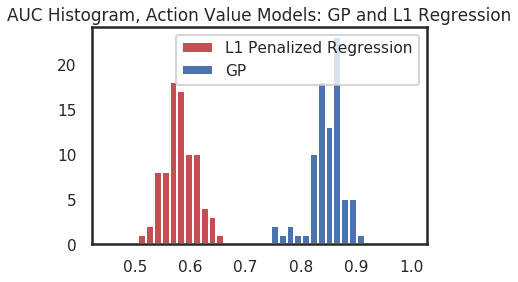

In [7]:
sns.set(style="white",context='poster', font_scale=.7,font='arial')
bins = np.linspace(0.45, 1, 40)
plt.hist(subAUC,bins,color='r',label='L1 Penalized Regression')
plt.hist(aucs_GP,bins,label='GP')
plt.legend()
plt.title("AUC Histogram, Action Value Models: GP and L1 Regression");
plt.savefig("presentationplots/AUCHistogramValueComparison.svg",bbox_inches='tight')

# Look at the early/middle/late thirds of trials and see if there are differences in how EML EV predict win/loss at end of trial, and whether this differs as a function of goalie opponent identity

In [4]:
logreg_coef_early_human = []
logreg_coef_middle_human = []
logreg_coef_late_human = []
logreg_coef_early_cpu = []
logreg_coef_middle_cpu = []
logreg_coef_late_cpu = []

df = PKutils.loaddf()

for subID in range(82):
    print(subID)
    
    subdf = df[df['subID']==subID]
    #subdf["result"] = subdf.result.replace({'L':0,'W':1})
    subdf["EV"] = PKutils.calculateExtraEV(subID)
    
    earlyindex = subdf[subdf.time<=44] #early is tp 20-44
    middleindex = subdf[(subdf['time'] >= 45) & (subdf['time'] <=69 )] #middle is tp 45-69
    lateindex = subdf[(subdf['time'] >= 70) & (subdf['time'] <=93 )] #late tp is 70-93 NOT INCLUDING 94,95,96 (the outcome)!
    
    #divide EML by opponent
    earlyhuman = earlyindex[earlyindex["opp"] == 1]
    earlycpu = earlyindex[earlyindex["opp"] == 0]
    middlehuman = middleindex[middleindex["opp"] == 1]
    middlecpu = middleindex[middleindex["opp"] == 0]
    latehuman = lateindex[lateindex["opp"] == 1]
    latecpu = lateindex[lateindex["opp"] == 0]

    #Do the regressions:
    reg = sm.Logit(earlyhuman["result"], earlyhuman["EV"])
    result = reg.fit()
    logreg_coef_early_human.append(result.params[0])
    
    reg = sm.Logit(earlycpu["result"], earlycpu["EV"])
    result = reg.fit()
    logreg_coef_early_cpu.append(result.params[0])
    
    reg = sm.Logit(middlehuman["result"], middlehuman["EV"])
    result = reg.fit()
    logreg_coef_middle_human.append(result.params[0])
    
    reg = sm.Logit(middlecpu["result"], middlecpu["EV"])
    result = reg.fit()
    logreg_coef_middle_cpu.append(result.params[0])
    
    reg = sm.Logit(latehuman["result"], latehuman["EV"])
    result = reg.fit()
    logreg_coef_late_human.append(result.params[0])
    
    reg = sm.Logit(latecpu["result"], latecpu["EV"])
    result = reg.fit()
    logreg_coef_late_cpu.append(result.params[0])

0
Optimization terminated successfully.
         Current function value: 0.617154
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.672660
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.547137
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639087
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.415200
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.522935
         Iterations 6
1
Optimization terminated successfully.
         Current function value: 0.687647
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678580
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.620278
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.65292

Optimization terminated successfully.
         Current function value: 0.683779
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690677
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.619564
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.669286
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.481671
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.559218
         Iterations 6
15
Optimization terminated successfully.
         Current function value: 0.666753
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685340
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.616828
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.665408

Optimization terminated successfully.
         Current function value: 0.587439
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584182
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.526150
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.517916
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.335466
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.334099
         Iterations 7
29
Optimization terminated successfully.
         Current function value: 0.585522
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600152
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.520759
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554874

Optimization terminated successfully.
         Current function value: 0.686453
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679919
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.644278
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.661394
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.522701
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.577846
         Iterations 5
43
Optimization terminated successfully.
         Current function value: 0.641733
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.610695
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552610
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.510781

Optimization terminated successfully.
         Current function value: 0.690104
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692227
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.604989
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.683014
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.540544
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.579597
         Iterations 5
57
Optimization terminated successfully.
         Current function value: 0.692087
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.673143
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.669172
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.646974

Optimization terminated successfully.
         Current function value: 0.677354
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692348
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.544895
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.650892
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.460826
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.550083
         Iterations 6
71
Optimization terminated successfully.
         Current function value: 0.683671
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691938
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.633628
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.678483

In [5]:
humanbetas = np.concatenate((logreg_coef_early_human, logreg_coef_middle_human, logreg_coef_late_human))
cpubetas = np.concatenate((logreg_coef_early_cpu, logreg_coef_middle_cpu, logreg_coef_late_cpu))

In [6]:
earlybetas = np.concatenate((logreg_coef_early_human,logreg_coef_early_cpu)) 
midbetas = np.concatenate((logreg_coef_middle_human, logreg_coef_middle_cpu))
latebetas = np.concatenate((logreg_coef_late_human, logreg_coef_late_cpu))

In [7]:
stats.ttest_ind(humanbetas, cpubetas)

Ttest_indResult(statistic=4.5259523273958076, pvalue=7.555206500964035e-06)

In [8]:
stats.ttest_ind(earlybetas, latebetas)

Ttest_indResult(statistic=-30.68996797364703, pvalue=3.648719144683262e-98)

In [9]:
std = [stats.sem(logreg_coef_early_cpu), stats.sem(logreg_coef_early_human), stats.sem(logreg_coef_middle_cpu), stats.sem(logreg_coef_middle_human), stats.sem(logreg_coef_late_cpu), 
       stats.sem(logreg_coef_late_human)]

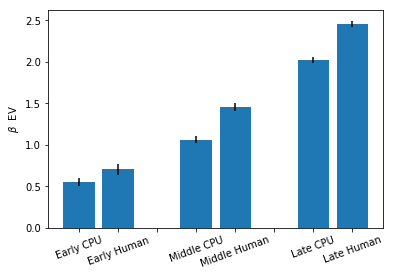

In [10]:
plt.bar([0,1,3,4,6,7],[np.mean(logreg_coef_early_cpu), np.mean(logreg_coef_early_human), np.mean(logreg_coef_middle_cpu),np.mean(logreg_coef_middle_human), np.mean(logreg_coef_late_cpu), np.mean(logreg_coef_late_human)],yerr=std)
plt.xticks(np.arange(8),["Early CPU","Early Human","","Middle CPU","Middle Human","","Late CPU","Late Human"],rotation=20);
plt.ylabel(r'$\beta $  EV');
plt.savefig("presentationplots/EML_EV.svg",bbox_inches='tight')

# Make supplement plots of EV and KDE for subs [3,4,12,56]

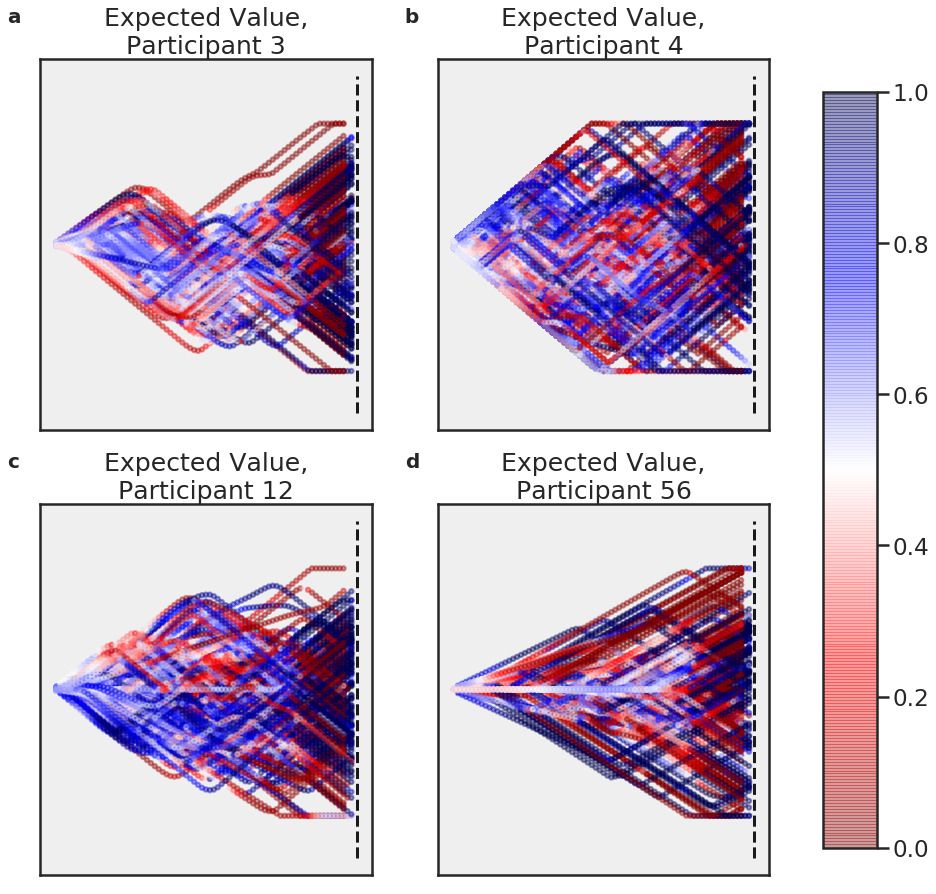

In [13]:
sns.set(style="white",context='poster', font_scale=1.05,font='arial')
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(15,15))
goalLine = 920

#Plot 1
subID = 3
inputdata, subtargets, X_train, X_test, y_train, y_test = PKutils.loaddata(subID,whichModel='ExtraEV')
probs = PKutils.calculateExtraEV(subID)
EVdf = pd.DataFrame(probs, columns=['probs'])
subdf = df[df.subID==subID]
EVdf["trialidx"] = subdf.super_index.values
EVdf["timepoint"] = subdf.time.values 
EVdf["xpos"] = inputdata[1].values
EVdf["ypos"] = inputdata[2].values
ax1.set_facecolor(ps_colors[0])
biggest = np.max(EVdf["probs"])
cax = ax1.scatter(EVdf["xpos"], EVdf["ypos"], c=EVdf["probs"], cmap="seismic_r", alpha=0.4, s=20, vmin=0, vmax=1);
ax1.get_yaxis().set_visible(False)
ax1.get_xaxis().set_visible(False)
ax1.vlines([goalLine/1024.*2-1], -1, 1, linestyle='dashed');
ax1.text(-0.1, 1.1, 'a', transform=ax1.transAxes, size=20, weight='bold')
ax1.set_title("Expected Value,\nParticipant {}".format(subID))

#Plot 2
subID = 4
inputdata, subtargets, X_train, X_test, y_train, y_test = PKutils.loaddata(subID,whichModel='ExtraEV')
probs = PKutils.calculateExtraEV(subID)
EVdf = pd.DataFrame(probs, columns=['probs'])
subdf = df[df.subID==subID]
EVdf["trialidx"] = subdf.super_index.values
EVdf["timepoint"] = subdf.time.values 
EVdf["xpos"] = inputdata[1].values
EVdf["ypos"] = inputdata[2].values
ax2.set_facecolor(ps_colors[0])
biggest = np.max(EVdf["probs"])
cax = ax2.scatter(EVdf["xpos"], EVdf["ypos"], c=EVdf["probs"], cmap="seismic_r", alpha=0.4, s=20, vmin=0, vmax=1);
ax2.get_yaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)
ax2.vlines([goalLine/1024.*2-1], -1, 1, linestyle='dashed');
ax2.text(-0.1, 1.1, 'b', transform=ax2.transAxes, size=20, weight='bold')
ax2.set_title("Expected Value,\nParticipant {}".format(subID))

#Plot 3
subID = 12
inputdata, subtargets, X_train, X_test, y_train, y_test = PKutils.loaddata(subID,whichModel='ExtraEV')
probs = PKutils.calculateExtraEV(subID)
EVdf = pd.DataFrame(probs, columns=['probs'])
subdf = df[df.subID==subID]
EVdf["trialidx"] = subdf.super_index.values
EVdf["timepoint"] = subdf.time.values 
EVdf["xpos"] = inputdata[1].values
EVdf["ypos"] = inputdata[2].values
ax3.set_facecolor(ps_colors[0])
biggest = np.max(EVdf["probs"])
cax = ax3.scatter(EVdf["xpos"], EVdf["ypos"], c=EVdf["probs"], cmap="seismic_r", alpha=0.4, s=20, vmin=0, vmax=1);
ax3.get_yaxis().set_visible(False)
ax3.get_xaxis().set_visible(False)
ax3.vlines([goalLine/1024.*2-1], -1, 1, linestyle='dashed');
ax3.text(-0.1, 1.1, 'c', transform=ax3.transAxes, size=20, weight='bold')
ax3.set_title("Expected Value,\nParticipant {}".format(subID))

#Plot 4
subID = 56
inputdata, subtargets, X_train, X_test, y_train, y_test = PKutils.loaddata(subID,whichModel='ExtraEV')
probs = PKutils.calculateExtraEV(subID)
EVdf = pd.DataFrame(probs, columns=['probs'])
subdf = df[df.subID==subID]
EVdf["trialidx"] = subdf.super_index.values
EVdf["timepoint"] = subdf.time.values 
EVdf["xpos"] = inputdata[1].values
EVdf["ypos"] = inputdata[2].values
ax4.set_facecolor(ps_colors[0])
biggest = np.max(EVdf["probs"])
cax = ax4.scatter(EVdf["xpos"], EVdf["ypos"], c=EVdf["probs"], cmap="seismic_r", alpha=0.4, s=20, vmin=0, vmax=1);
ax4.get_yaxis().set_visible(False)
ax4.get_xaxis().set_visible(False)
ax4.vlines([goalLine/1024.*2-1], -1, 1, linestyle='dashed');
ax4.text(-0.1, 1.1, 'd', transform=ax4.transAxes, size=20, weight='bold')
ax4.set_title("Expected Value,\nParticipant {}".format(subID))

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(cax, cax=cbar_ax)
plt.savefig("presentationplots/allsubsupplement_EV.pdf")

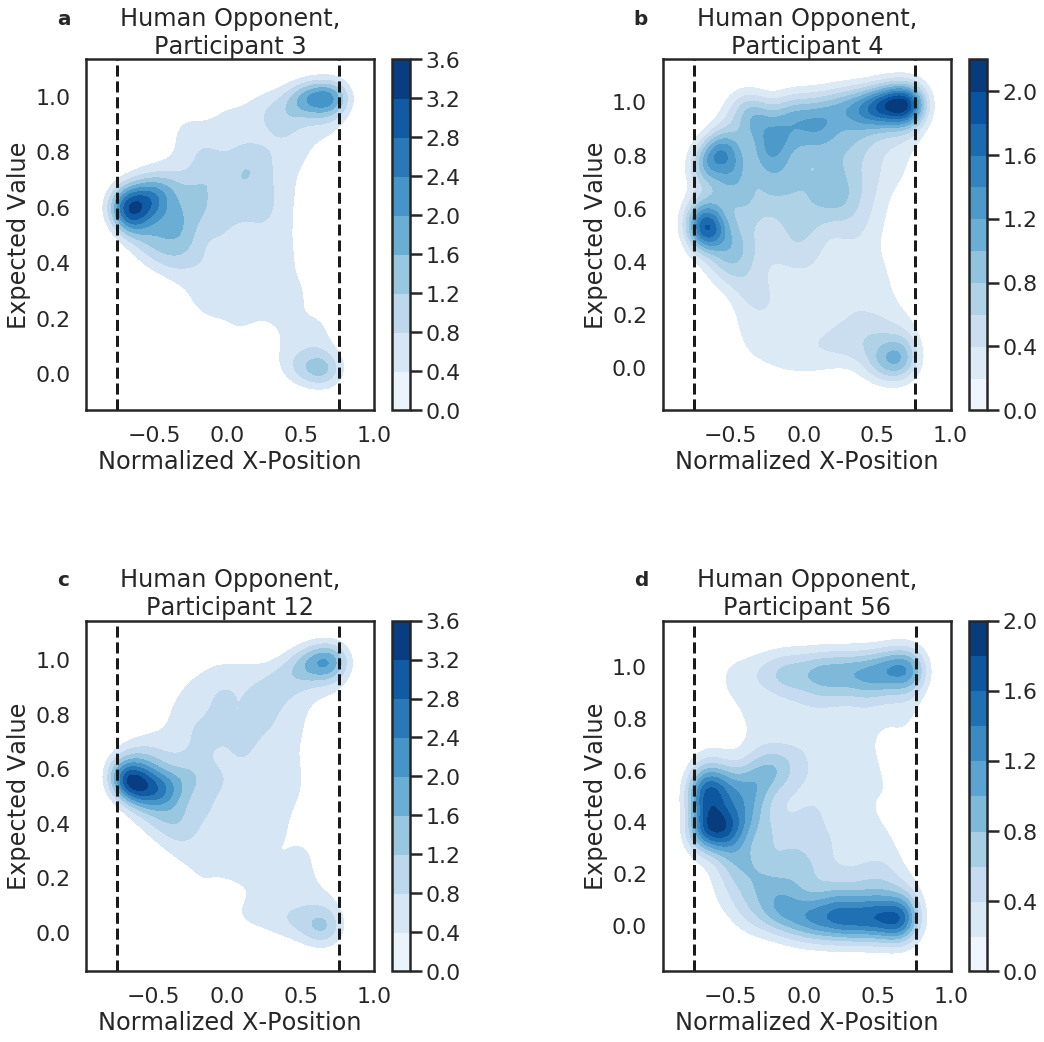

In [16]:
sns.set(style="white",context='poster', font_scale=1.0,font='arial')
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(15,15))

df["EV"] = np.load("EVdata.npy")
df = df.round(2)

#Plot 1
subID = 3
subdf = df[df['subID']==subID]
subhumandf = subdf[subdf["opp"]==1]
subcpudf = subdf[subdf["opp"]==0]
humankdesub3 = sns.kdeplot(subhumandf["ball_xpos"], subhumandf["EV"],shade=True, shade_lowest=False,cmap="Blues",ax=ax1,cbar=True);
ax1.axvline(-.75, 0,1,linestyle='dashed',color='k')
ax1.axvline(.76,0,1,linestyle='dashed',color='k')
ax1.set_title("Human Opponent,\nParticipant {}".format(subID))
ax1.set_yticks([0.0,0.2,0.4,0.6,0.8,1.0])
ax1.set_xlabel("Normalized X-Position")
ax1.set_ylabel("Expected Value")
ax1.text(-0.1, 1.1, 'a', transform=ax1.transAxes, size=20, weight='bold')

#Plot 2
subID = 4
subdf = df[df['subID']==subID]
subhumandf = subdf[subdf["opp"]==1]
subcpudf = subdf[subdf["opp"]==0]
humankdesub3 = sns.kdeplot(subhumandf["ball_xpos"], subhumandf["EV"],shade=True, shade_lowest=False,cmap="Blues",ax=ax2,cbar=True);
ax2.axvline(-.75, 0,1,linestyle='dashed',color='k')
ax2.axvline(.76,0,1,linestyle='dashed',color='k')
ax2.set_title("Human Opponent,\nParticipant {}".format(subID))
ax2.set_xlabel("Normalized X-Position")
ax2.set_ylabel("Expected Value")
ax2.set_yticks([0.0,0.2,0.4,0.6,0.8,1.0])
ax2.text(-0.1, 1.1, 'b', transform=ax2.transAxes, size=20, weight='bold')

#Plot 3
subID = 12
subdf = df[df['subID']==subID]
subhumandf = subdf[subdf["opp"]==1]
subcpudf = subdf[subdf["opp"]==0]
humankdesub3 = sns.kdeplot(subhumandf["ball_xpos"], subhumandf["EV"],shade=True, shade_lowest=False,cmap="Blues",ax=ax3,cbar=True);
ax3.axvline(-.75, 0,1,linestyle='dashed',color='k')
ax3.axvline(.76,0,1,linestyle='dashed',color='k')
ax3.set_title("Human Opponent,\nParticipant {}".format(subID))
ax3.set_yticks([0.0,0.2,0.4,0.6,0.8,1.0])
ax3.set_xlabel("Normalized X-Position")
ax3.set_ylabel("Expected Value")
ax3.text(-0.1, 1.1, 'c', transform=ax3.transAxes, size=20, weight='bold')

#Plot 4
subID = 56
subdf = df[df['subID']==subID]
subhumandf = subdf[subdf["opp"]==1]
subcpudf = subdf[subdf["opp"]==0]
humankdesub3 = sns.kdeplot(subhumandf["ball_xpos"], subhumandf["EV"],shade=True, shade_lowest=False,cmap="Blues",ax=ax4,cbar=True);
ax4.axvline(-.75, 0,1,linestyle='dashed',color='k')
ax4.axvline(.76,0,1,linestyle='dashed',color='k')
ax4.set_title("Human Opponent,\nParticipant {}".format(subID))
ax4.set_yticks([0.0,0.2,0.4,0.6,0.8,1.0])
ax4.set_xlabel("Normalized X-Position")
ax4.set_ylabel("Expected Value")
ax4.text(-0.1, 1.1, 'd', transform=ax4.transAxes, size=20, weight='bold')

plt.tight_layout()
plt.subplots_adjust(wspace=0.6,hspace=0.6)
plt.savefig("presentationplots/allsubhumanKDE_supplement.pdf",bbox_inches='tight') 

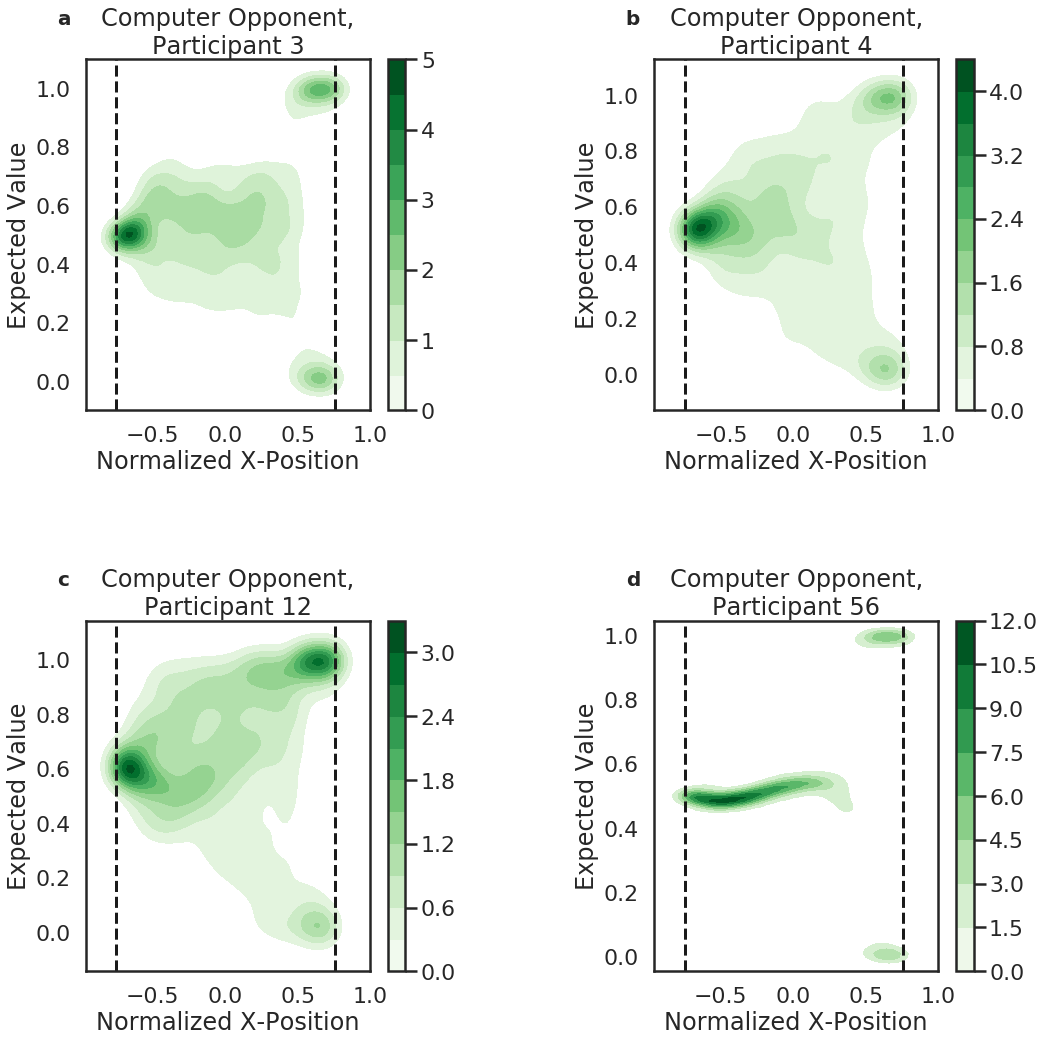

In [17]:
sns.set(style="white",context='poster', font_scale=1.0,font='arial')
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(15,15))

#Plot 1
subID = 3
subdf = df[df['subID']==subID]
subhumandf = subdf[subdf["opp"]==1]
subcpudf = subdf[subdf["opp"]==0]
humankdesub3 = sns.kdeplot(subcpudf["ball_xpos"], subcpudf["EV"],shade=True, shade_lowest=False,cmap="Greens",ax=ax1,cbar=True);
ax1.axvline(-.75, 0,1,linestyle='dashed',color='k')
ax1.axvline(.76,0,1,linestyle='dashed',color='k')
ax1.set_title("Computer Opponent,\nParticipant {}".format(subID))
ax1.set_yticks([0.0,0.2,0.4,0.6,0.8,1.0])
ax1.set_xlabel("Normalized X-Position")
ax1.set_ylabel("Expected Value")
ax1.text(-0.1, 1.1, 'a', transform=ax1.transAxes, size=20, weight='bold')

#Plot 2
subID = 4
subdf = df[df['subID']==subID]
subhumandf = subdf[subdf["opp"]==1]
subcpudf = subdf[subdf["opp"]==0]
humankdesub3 = sns.kdeplot(subcpudf["ball_xpos"], subcpudf["EV"],shade=True, shade_lowest=False,cmap="Greens",ax=ax2,cbar=True);
ax2.axvline(-.75, 0,1,linestyle='dashed',color='k')
ax2.axvline(.76,0,1,linestyle='dashed',color='k')
ax2.set_title("Computer Opponent,\nParticipant {}".format(subID))
ax2.set_xlabel("Normalized X-Position")
ax2.set_ylabel("Expected Value")
ax2.set_yticks([0.0,0.2,0.4,0.6,0.8,1.0])
ax2.text(-0.1, 1.1, 'b', transform=ax2.transAxes, size=20, weight='bold')

#Plot 3
subID = 12
subdf = df[df['subID']==subID]
subhumandf = subdf[subdf["opp"]==1]
subcpudf = subdf[subdf["opp"]==0]
humankdesub3 = sns.kdeplot(subcpudf["ball_xpos"], subcpudf["EV"],shade=True, shade_lowest=False,cmap="Greens",ax=ax3,cbar=True);
ax3.axvline(-.75, 0,1,linestyle='dashed',color='k')
ax3.axvline(.76,0,1,linestyle='dashed',color='k')
ax3.set_title("Computer Opponent,\nParticipant {}".format(subID))
ax3.set_yticks([0.0,0.2,0.4,0.6,0.8,1.0])
ax3.set_xlabel("Normalized X-Position")
ax3.set_ylabel("Expected Value")
ax3.text(-0.1, 1.1, 'c', transform=ax3.transAxes, size=20, weight='bold')

#Plot 4
subID = 56
subdf = df[df['subID']==subID]
subhumandf = subdf[subdf["opp"]==1]
subcpudf = subdf[subdf["opp"]==0]
humankdesub3 = sns.kdeplot(subcpudf["ball_xpos"], subcpudf["EV"],shade=True, shade_lowest=False,cmap="Greens",ax=ax4,cbar=True);
ax4.axvline(-.75, 0,1,linestyle='dashed',color='k')
ax4.axvline(.76,0,1,linestyle='dashed',color='k')
ax4.set_title("Computer Opponent,\nParticipant {}".format(subID))
ax4.set_yticks([0.0,0.2,0.4,0.6,0.8,1.0])
ax4.set_xlabel("Normalized X-Position")
ax4.set_ylabel("Expected Value")
ax4.text(-0.1, 1.1, 'd', transform=ax4.transAxes, size=20, weight='bold')

plt.tight_layout()
plt.subplots_adjust(wspace=0.6,hspace=0.6)
plt.savefig("presentationplots/allsubcpuKDE_supplement.pdf",bbox_inches='tight') 